# CNN Cancer Detection

In [1]:
import numpy as np
import pandas as pd
import os
import time
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
import seaborn as sns
from PIL import Image
from tensorflow import keras
import tensorflow_io as tfio
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from tensorflow.keras.models import load_model
from sklearn.utils import resample

## Description

Create an algorithm to identify metastatic cancer in small image patches taken from larger digital pathology scans using CNN model

## EDA

I created the train_data_path with "/" at the end to avoid being adding it everytime on the code

In [2]:
train_data_path = '../input/histopathologic-cancer-detection/train/'

In [3]:
len_train = len(os.listdir(train_data_path))
len_train

220025

But, I didn't put for the test data because it's not needed

In [4]:
test_data_path = '../input/histopathologic-cancer-detection/test'

In [5]:
len_test = len(os.listdir(test_data_path))
len_test

57458

Checking both Train and Test Data we can see that all pictures are in .TIF which means they have a higher quality than .PNG or .JPEG. .TIF or .TIFF are used in professinal photografy world and for a investigation of cancer, those images have to have a high-end quality and that's the why those images are in .TIF

They all have the same size 27.94kb

In [6]:
label_data = pd.read_csv('../input/histopathologic-cancer-detection/train_labels.csv')

In [7]:
label_data

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0
...,...,...
220020,53e9aa9d46e720bf3c6a7528d1fca3ba6e2e49f6,0
220021,d4b854fe38b07fe2831ad73892b3cec877689576,1
220022,3d046cead1a2a5cbe00b2b4847cfb7ba7cf5fe75,0
220023,f129691c13433f66e1e0671ff1fe80944816f5a2,0


In [8]:
label_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220025 entries, 0 to 220024
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   id      220025 non-null  object
 1   label   220025 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.4+ MB


In [9]:
label_data.describe()

,label
count,220025.000000
mean,0.405031
std,0.490899
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


In [10]:
label_count = label_data['label'].value_counts()

In [11]:
label_count

label
0    130908
1     89117
Name: count, dtype: int64

In [12]:
labels = label_data['label'].values

In [13]:
labels

array([0, 1, 0, ..., 0, 0, 1])

0 means the image has no tumor tissue  
1 means the image has tumor tissue

Text(0, 0.5, 'Propotion')

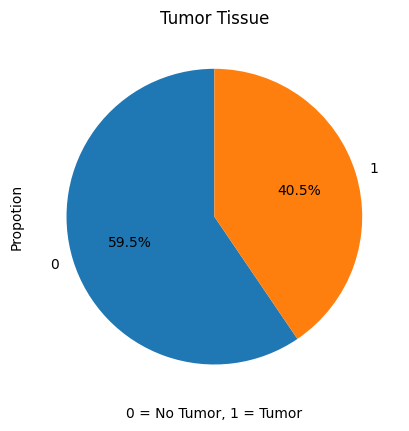

In [14]:
plt.pie(label_count, labels = [0,1], startangle=90, autopct='%1.1f%%')
plt.title('Tumor Tissue')
plt.xlabel('0 = No Tumor, 1 = Tumor')
plt.ylabel('Propotion')

As the Training data has 40.5% of tumor tissue and 59.5% with no tumor issue, this data is not consided imbalanced.

In [15]:
label_data['id'].value_counts()

id
f38a6374c348f90b587e046aac6079959adf3835    1
33e170e24f1455a38e331ae45185edf3130cdd6a    1
bd933b010960ffb209cf49b70a107aa29bf44f73    1
787b356e4baa34b7a91394fdf8c97f9da6e6d644    1
16f255bbb6177df95469f25bc666c19f863133db    1
                                           ..
8834ed9090df483276631a8b78e127472b3d9e52    1
a41522430a70ed45f3d65edb0911e1a4562308cd    1
98723a0bbca6bc0c6c6029435ebe3650d2184c42    1
493c1c2594e164fe91f7cd5425ff2fad8460c7b5    1
a81f84895ddcd522302ddf34be02eb1b3e5af1cb    1
Name: count, Length: 220025, dtype: int64

There are no duplicates id in the label data

In [16]:
len_train/(len_test+len_train)

0.7929314588641466

In [17]:
len_test/(len_test+len_train)

0.20706854113585338

As the training data is 79.3% of the total data and test data is 20.7%, It is recommended to have the validation data as approximaly the same size as test data, so I will split the training data in 60% and 19.3%, to leave the training data with at least 60% of the total data.

In [18]:
len_val = (len_test+len_train)*0.193
len_val

53554.219000000005

In [19]:
split_rate = len_val/len_train
split_rate

0.2434006090217021

In [20]:
label_data['id'][10]

'a106469bbfda4cdc5a9da7ac0152927bf1b4a92d'

Showing few of the imaging and labels of the training data

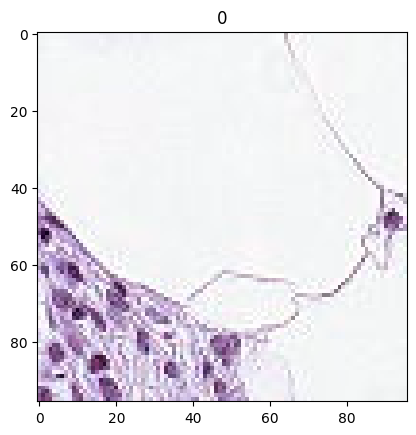

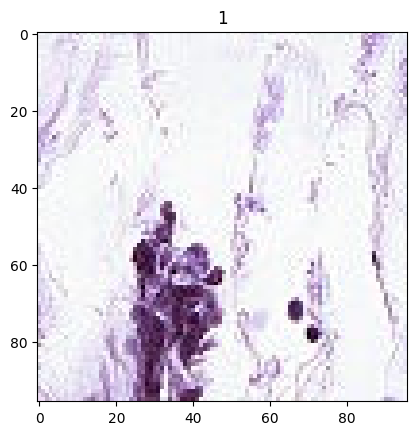

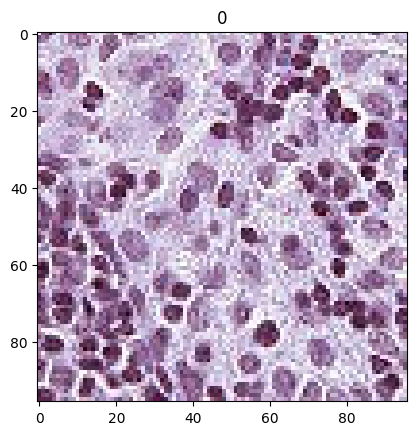

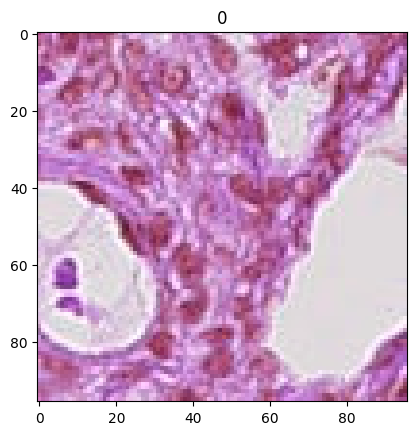

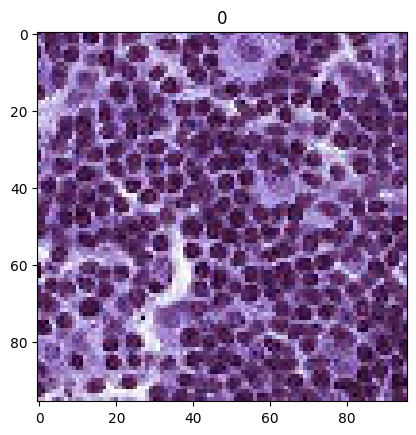

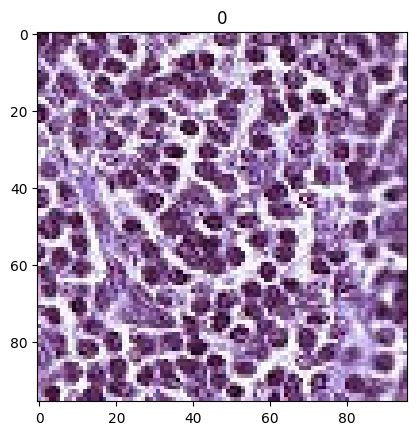

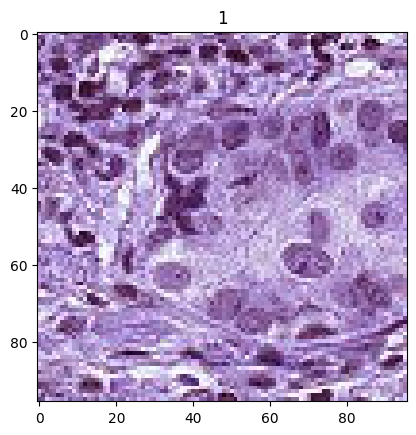

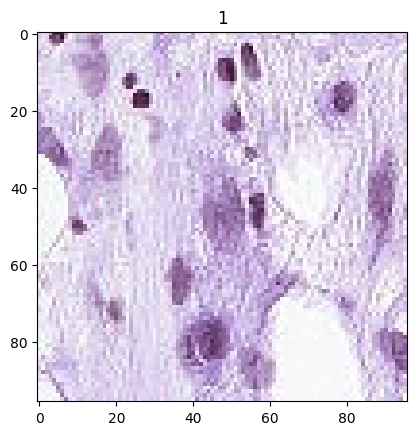

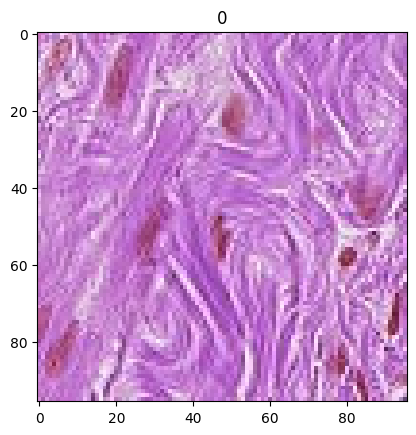

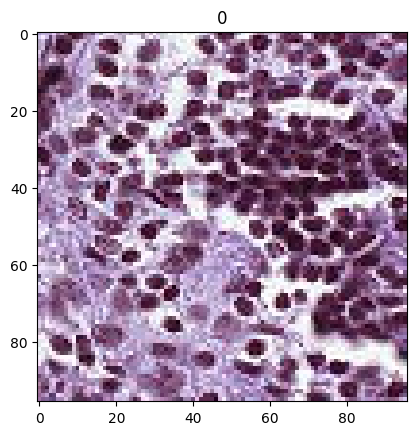

In [21]:
for i in range(10):
    label_data['id'][i]
    im=cv2.imread(train_data_path + label_data['id'][i] +'.tif')
    f, ax = plt.subplots()
    plt.title(label_data['label'][i])
    ax.imshow(im, resample=True, cmap='gray')

As I had explained above, as the data is not considered imbalanced, so I will use the how train data to divide in training and valid data

## DModel Architecture

I've used the CNN architecture presented by @fmarazzi in this kernel:
https://www.kaggle.com/fmarazzi/baseline-keras-cnn-roc-fast-5min-0-8253-lb

The achitecture is simple: the model has relu as hidden activation fuctions and sigmoid for output because it is a single classification model

In [22]:
kernel_size = (3,3)
pool_size= (2,2)
first_filters = 32
second_filters = 64
third_filters = 128

dropout_conv = 0.3
dropout_dense = 0.3


model = Sequential()
model.add(Conv2D(first_filters, kernel_size, activation = 'relu', input_shape = (96, 96, 3)))
model.add(Conv2D(first_filters, kernel_size, activation = 'relu'))
model.add(Conv2D(first_filters, kernel_size, activation = 'relu'))
model.add(MaxPooling2D(pool_size = pool_size)) 
model.add(Dropout(dropout_conv))

model.add(Conv2D(second_filters, kernel_size, activation ='relu'))
model.add(Conv2D(second_filters, kernel_size, activation ='relu'))
model.add(Conv2D(second_filters, kernel_size, activation ='relu'))
model.add(MaxPooling2D(pool_size = pool_size))
model.add(Dropout(dropout_conv))

model.add(Conv2D(third_filters, kernel_size, activation ='relu'))
model.add(Conv2D(third_filters, kernel_size, activation ='relu'))
model.add(Conv2D(third_filters, kernel_size, activation ='relu'))
model.add(MaxPooling2D(pool_size = pool_size))
model.add(Dropout(dropout_conv))

model.add(Flatten())
model.add(Dense(512, activation = "relu"))
model.add(Dropout(dropout_dense))
model.add(Dense(1, activation = "sigmoid"))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 94, 94, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 92, 92, 32)        9248      
                                                                 
 conv2d_2 (Conv2D)           (None, 90, 90, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 45, 45, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 45, 45, 32)        0         
                                                                 
 conv2d_3 (Conv2D)           (None, 43, 43, 64)        18496     
                                                        

In [23]:
from tensorflow.keras.optimizers import Adam

optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

In [24]:
label_data['label'] = label_data['label'].astype(str)  # Convert label column to string

My computer couldn't support to run the whole train data, not even a small part, so I used only he head 1000 to train my model,which is not ideal with batches size of 128. Number of epochs were 5 to speed the running process, by the epoch 2 my model is already tending to overfit because of the amount of data train I had to give

In [25]:
# Add the .tif extension to the 'id' column for correct file referencing
label_data['id'] = label_data['id'].apply(lambda x: f"{x}.tif")

# Preparing data generators
train_datagen = ImageDataGenerator(rescale=1./255, validation_split=split_rate)  # Normalize images

batch_size = 128
train_steps = 1000*(1-split_rate) // batch_size  
val_steps = 1000*split_rate // batch_size    

train_gen = train_datagen.flow_from_dataframe(
    dataframe=label_data.head(1000),
    directory=train_data_path,
    x_col='id',
    y_col='label',
    target_size=(96, 96),
    class_mode='binary',
    batch_size=batch_size,
    subset='training'
)

val_gen = train_datagen.flow_from_dataframe(
    dataframe=label_data.head(1000),
    directory=train_data_path,
    x_col='id',
    y_col='label',
    target_size=(96, 96),
    class_mode='binary',
    batch_size=batch_size,
    subset='validation'
)

# Training the model
history = model.fit(
    train_gen,
    steps_per_epoch=train_steps,
    validation_data=val_gen,
    validation_steps=val_steps,
    epochs=5
)

Found 757 validated image filenames belonging to 2 classes.
Found 243 validated image filenames belonging to 2 classes.
Epoch 1/5
5/5 [==============================] - 32s 6s/step - loss: 0.6826 - accuracy: 0.5406 - val_loss: 0.6732 - val_accuracy: 0.6016
Epoch 2/5
5/5 [==============================] - 29s 6s/step - loss: 0.6606 - accuracy: 0.6089 - val_loss: 0.6719 - val_accuracy: 0.5938
Epoch 3/5
5/5 [==============================] - 28s 6s/step - loss: 0.6695 - accuracy: 0.5946 - val_loss: 0.6843 - val_accuracy: 0.5625
Epoch 4/5
5/5 [==============================] - 28s 6s/step - loss: 0.6606 - accuracy: 0.6041 - val_loss: 0.6942 - val_accuracy: 0.4844
Epoch 5/5
5/5 [==============================] - 28s 6s/step - loss: 0.6708 - accuracy: 0.5835 - val_loss: 0.6796 - val_accuracy: 0.5547


In [26]:
test_ids = [filename[:-4] for filename in os.listdir(test_data_path)]
test_filenames = [os.path.join(test_data_path, filename) for filename in os.listdir(test_data_path)]
test_df = pd.DataFrame()
test_df["id"] = test_ids
test_df["filename"] = test_filenames

In [27]:
test_generator = train_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col="filename",
    y_col=None,
    target_size=(96, 96),
    color_mode="rgb",
    batch_size=batch_size,
    shuffle=False,
    class_mode=None,
    validate_filenames=False
)

Found 57458 non-validated image filenames.


In [28]:
test_probs = model.predict(test_generator)
test_labels = np.round(test_probs).astype(int).flatten()
out_df = pd.DataFrame()
out_df["id"] = test_ids
out_df["label"] = test_labels

449/449 [==============================] - 653s 1s/step


In [29]:
out_df

,id,label
0,a7ea26360815d8492433b14cd8318607bcf99d9e,0
1,59d21133c845dff1ebc7a0c7cf40c145ea9e9664,0
2,5fde41ce8c6048a5c2f38eca12d6528fa312cdbb,0
3,bd953a3b1db1f7041ee95ff482594c4f46c73ed0,0
4,523fc2efd7aba53e597ab0f69cc2cbded7a6ce62,0
...,...,...
57453,7907c88a7f5f9c8ca5b2df72c1e6ff9650eea22b,0
57454,2a6fc1ed16fa94d263efab330ccbeb1906cbd421,0
57455,6bb5c0611c0ccf4713e0ccbc0e8c54bcb498ef14,0
57456,f11e7c9e77cbc1ec916a52e6b871a293ee1bb928,0


In [30]:
out_df.to_csv('/kaggle/working/submission.csv', index=False)

In [31]:
pd.read_csv('/kaggle/working/submission.csv')

,id,label
0,a7ea26360815d8492433b14cd8318607bcf99d9e,0
1,59d21133c845dff1ebc7a0c7cf40c145ea9e9664,0
2,5fde41ce8c6048a5c2f38eca12d6528fa312cdbb,0
3,bd953a3b1db1f7041ee95ff482594c4f46c73ed0,0
4,523fc2efd7aba53e597ab0f69cc2cbded7a6ce62,0
...,...,...
57453,7907c88a7f5f9c8ca5b2df72c1e6ff9650eea22b,0
57454,2a6fc1ed16fa94d263efab330ccbeb1906cbd421,0
57455,6bb5c0611c0ccf4713e0ccbc0e8c54bcb498ef14,0
57456,f11e7c9e77cbc1ec916a52e6b871a293ee1bb928,0


## Conclusion

My model preditct 50% of the results, the low value is due to the points below:
 - My computer couldn't support to run a database with images like that, it was too big for my processing.
 - The CCN architeture I chose is slower than other ones I saw around
 - I used only 1000 pictures
 - I used only the head 1000

My model proposition was to split the train data in a way we had train with 60%, validation data with 20% and test data with 20%. Train data + test data = 100%, test data was already 20%, so I decided to split train data in train and validation data to make that happen.
If I had a better computer using SGUs to support runnning it, my model will be better trainined and my results would have been much better.